# 🏠 Predictive Modeling of Edmonton Property Prices

This notebook builds a machine learning model to estimate property sale prices in Edmonton using:

- **Property features** (e.g., beds, baths, garage, year built)
- **Neighborhood context** (e.g., crime levels, planning districts)
- **Engineered features** (e.g., ratios, encoded variables)

---

### Project Workflow

1. **Data Loading & Cleaning** – Import and clean property, crime, and neighborhood datasets.
2. **Data Integration** – Merge datasets into a unified table at the property level.
3. **Feature Engineering** – Derive additional informative features.
4. **Modeling** – Train and tune ML models: Linear Regression, Random Forest, XGBoost.
5. **Evaluation & Interpretation** – Use RMSE, R², feature importance, and SHAP for insights.

Our goal is to support **real estate pricing decisions** with accurate, explainable, and actionable models.


## Step 1: Data Loading and Initial Setup

We import core libraries for data manipulation, visualization, and modeling.  
Then we load the following datasets:

- `sold_df`: Cleaned property sales data
- `crime_df`: Crime incidents aggregated by neighborhood
- `neighbourhoods_df`: Geographic and planning district metadata for Edmonton

To ensure consistency, all column names are standardized to lowercase with underscores.


In [1]:
# Core libraries for EDA and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning utilities
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Ignore a specific warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning,
                        message="Skipping features without any observed values")

# Load CSV datasets
sold_df = pd.read_csv('/Users/glennbarnes/Documents/DATA3960/1242_Project_Group_3/1.Data/cleaned_edm_sold_data_v2.4.csv')
crime_df = pd.read_csv('/Users/glennbarnes/Documents/DATA3960/1242_Project_Group_3/1.Data/Crime_Data_with_Neighborhoods.csv')
neighbourhoods_df = pd.read_csv('/Users/glennbarnes/Documents/DATA3960/1242_Project_Group_3/1.Data/City_of_Edmonton_-_Neighbourhoods_20250211.csv')

# Standardize column naming for consistency
sold_df.rename(columns=lambda x: x.strip().replace(" ", "_").lower(), inplace=True)
crime_df.rename(columns=lambda x: x.strip().replace(" ", "_").lower(), inplace=True)
neighbourhoods_df.rename(columns=lambda x: x.strip().replace(" ", "_").lower(), inplace=True)



### 2. Data Exploration

We begin by inspecting the data structures and ensuring we understand the content and format of the datasets we're working with:

In [2]:
#Inspect the column names in each dataset
print(sold_df.columns)
print(crime_df.columns)
print(neighbourhoods_df.columns)

Index(['prop_class', 'area/city', 'community', 'status', 'list_price',
       'postal_code', 'sold_date', 'sold_price', 'listing_id_#', 'dom',
       'flrarea_sf', 'totflrarea', 'rooms_ag', 'bedrms_ag', 'beds',
       'full_baths', 'half_baths', 'baths', 'ensuite', 'yr_built', 'style',
       'front_exp', 'frontagem', 'fp_y/n', 'encl_park', 'parking',
       'construction_type', 'flooring', 'list_pr_/_sqft', '#_finished_levels',
       'cumulative_dom', 'cumulative_domls', 'days_on_mls', 'bsmt_dev',
       'garage_y/n', 'price', 'lot_sq_metres', 'carpet', 'hardwood',
       'linoleum', 'tile', 'laminate', 'vinyl_plank', 'geocode'],
      dtype='object')
Index(['occurrence_category', 'occurrence_group', 'occurrence_type_group',
       'intersection', 'date_reported', 'lat', 'long', 'neighborhood_name'],
      dtype='object')
Index(['neighbourhood_name', 'neighbourhood_number', 'descriptive_name',
       'description', 'effective_start_date', 'effective_end_date',
       'civic_ward', 'p

We also check the size of each dataset to estimate memory requirements and plan our analysis strategy:

In [3]:
# Check dataset sizes
print("Size of sold_data:", sold_df.shape)
print("Size of crime_data:", crime_df.shape)
print("Size of neighbourhoods_data:", neighbourhoods_df.shape)


Size of sold_data: (321943, 44)
Size of crime_data: (73448, 8)
Size of neighbourhoods_data: (405, 8)


The relevant columns related to neighborhood information:

- Sold Data (sold_df): The column is named `community` (likely equivalent to neighborhood).
- Crime Data (crime_df): The column is `neighborhood_name`.
- Neighborhoods Data (neighbourhoods_df): The column is `neighbourhood_name`.

We will now:
- Convert key columns to title case
- Drop unnecessary columns
- Standardize naming conventions (e.g., "avenue" -> "ave"
- Drop rows with missing values in key columns
- And merge them using the neighbourhood columns.


### 3. Data Cleaning and Merging

In [4]:
# Convert key columns to title case
sold_df["community"] = sold_df["community"].str.title()
crime_df["neighborhood_name"] = crime_df["neighborhood_name"].str.title()
neighbourhoods_df["neighbourhood_name"] = neighbourhoods_df["neighbourhood_name"].str.title()

# Drop unnecessary columns
sold_df = sold_df[["community", "yr_built", "beds", "full_baths", "garage_y/n", "lot_sq_metres", 'list_pr_/_sqft', "sold_price", 'sold_date',
                   "prop_class", "style", 'carpet', 'hardwood', 'linoleum', 'tile', 'laminate', 'vinyl_plank', 'geocode']]
crime_df = crime_df[["neighborhood_name", 'occurrence_category', 'occurrence_group', 'occurrence_type_group']]
neighborhoods_df = neighbourhoods_df[["neighbourhood_name", "neighbourhood_number", "civic_ward", "planning_district"]]

# Standardize naming conventions (e.g., 'avenue' -> 'ave')
sold_df['community'] = sold_df['community'].str.replace('Avenue', 'Ave', regex=False)
crime_df['neighborhood_name'] = crime_df['neighborhood_name'].str.replace('Avenue', 'Ave', regex=False)
neighbourhoods_df['neighbourhood_name'] = neighbourhoods_df['neighbourhood_name'].str.replace('Avenue', 'Ave', regex=False)

# Check unique values after cleaning
print("Unique values in sold data ['community']:", sold_df['community'].unique()[:10])
print("Unique values in crime data ['neighborhood_name']:", crime_df['neighborhood_name'].unique()[:10])
print("Unique values in neighbourhood data ['neighbourhood_name']:", neighbourhoods_df['neighbourhood_name'].unique()[:10])

# Drop rows with missing values in key columns
sold_df.dropna(subset=["community"], inplace=True)
crime_df.dropna(subset=["neighborhood_name"], inplace=True)
neighbourhoods_df.dropna(subset=["neighbourhood_name"], inplace=True)


Unique values in sold data ['community']: ['Abbottsfield' 'Albany' 'Alberta Ave' 'Aldergrove' 'Allard' 'Allendale'
 'Ambleside' 'Anthony Henday Energy Park' 'Anthony Henday South East'
 'Argyll']
Unique values in crime data ['neighborhood_name']: ['Mill Woods Town Centre' 'Duggan' 'La Perle' 'Edmonton Municipal Airport'
 'Lorelei' 'Rossdale' 'Summerlea' 'Glengarry' 'York' 'Tawa']
Unique values in neighbourhood data ['neighbourhood_name']: ['Abbottsfield' 'Albany' 'Alberta Ave' 'Alberta Park Industrial' 'Alces'
 'Aldergrove' 'Allard' 'Allendale' 'Ambleside' 'Anthony Henday']


### 4. Data Aggregation of Crime Dataset

The crime dataset is large and contains numerous duplicate neighborhood entries (likely one per incident).  Directly joining this dataset to the sold properties data results in millions of rows, exceeding memory capacity and hindering effective modeling.  To address this, the crime data is aggregated by neighborhood. This aggregation summarizes crime occurrences within each neighborhood, reducing the dataset size without losing critical neighborhood-level crime information. The aggregated data will then be merged with the sold property dataset, enabling a more manageable and computationally efficient analysis for modeling.




In [5]:
# Aggregate the crime dataset by counting incidents per neighbourhood
crime_summary = crime_df.groupby('neighborhood_name').size().reset_index(name='crime_count')

# Top5 Crime Neighbourhoods

crime_summary_sorted = crime_summary.sort_values(by='crime_count', ascending=False).head(5)
crime_summary_sorted


,neighborhood_name,crime_count
103,Downtown,2627
76,Central Mcdougall,2085
113,Edmonton Municipal Airport,1657
307,Rossdale,1614
80,Clareview Town Centre,1569


### 5. Merging Datasets (`Sold_df` and `crime_df`)

In [6]:
# Merge aggregated crime data with sold data
merged_df = pd.merge(sold_df, crime_summary, how='left', left_on='community', right_on='neighborhood_name')

# drop null values
merged_df.dropna(subset=["crime_count"], inplace=True)
merged_df.isnull().sum()

community            0
yr_built             0
beds                 0
full_baths           0
garage_y/n           0
lot_sq_metres        0
list_pr_/_sqft       0
sold_price           0
sold_date            0
prop_class           0
style                0
carpet               0
hardwood             0
linoleum             0
tile                 0
laminate             0
vinyl_plank          0
geocode              0
neighborhood_name    0
crime_count          0
dtype: int64

In [7]:
# Check how many rows successfully merged with crime data
print("Rows in merged data:", merged_df.shape[0])


Rows in merged data: 319494


### 6. Feature Engineering

Add derived variables that could help improve predictive power:
- `property_age`: How old the property is
- `total_rooms`: Simple measure of home size
- `has_garage`: Binary indicator for garage
- `crime_rate_per_capita`: Normalized crime level, etc
- `total_baths` or `full_baths`
- `yr_built_categories`, etc.


In [8]:
from datetime import datetime

# Copy the merged data to begin feature engineering
fe_data = merged_df.copy()

# --- Feature Engineering ---

# 1. Property Age
fe_data['property_age'] = 2025 - fe_data['yr_built']

# 2. Price per square foot (if flrarea_sf available)
if 'flrarea_sf' in fe_data.columns:
    fe_data['price_per_sqft'] = fe_data['sold_price'] / fe_data['flrarea_sf']
else:
    fe_data['price_per_sqft'] = None

# 3. Total Bathrooms (Full + 0.5 * Half)
if 'half_baths' in fe_data.columns:
    fe_data['total_baths'] = fe_data['full_baths'] + 0.5 * fe_data['half_baths']
else:
    fe_data['total_baths'] = fe_data['full_baths']

# 4. Bathroom per Bedroom Ratio (with proper replacement)
fe_data['bath_bed_ratio'] = fe_data['total_baths'] / fe_data['beds']
fe_data['bath_bed_ratio'] = fe_data['bath_bed_ratio'].replace([float('inf'), -float('inf')], None)

# 5. Crime Rate Category (based on quantiles)
fe_data['crime_rate_category'] = pd.qcut(fe_data['crime_count'], q=4, labels=['Low', 'Moderate', 'High', 'Very High'])

# 6. Garage presence as binary
fe_data['has_garage'] = fe_data['garage_y/n'].map({'Y': 1, 'N': 0})

# 7. Season of Sale
fe_data['sold_month'] = pd.to_datetime(fe_data['sold_date'], errors='coerce').dt.month
fe_data['sale_season'] = fe_data['sold_month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})


# 8. Categorize Year Built
def categorize_year_built(year):
    if year < 1980:
        return "Pre-1980"
    elif 1980 <= year <= 2000:
        return "1980-2000"
    elif 2000 < year <= 2020:
        return "2000-2020"
    else:
        return "2020+"

fe_data["year_built_category"] = fe_data["yr_built"].apply(categorize_year_built)

In [9]:
fe_data.drop(columns=['yr_built', 'sold_date', 'community', 'neighborhood_name'], inplace=True)

### 7. Feature Selection and Preprocessing

### Overview
Feature selection and preprocessing are critical steps in preparing the dataset for machine learning models. These steps ensure that the data is clean, relevant, and optimized for model performance.

### Key Steps
1. **Feature Selection**:
    - Selected features with sufficient variance using a threshold of `0.01`.
    - Retained numerical and categorical features that contribute to predictive power.

2. **Preprocessing**:
    - Numerical columns are scaled and imputed
    - Categorical coumns are one-hot encoded.
    - Pipelines are set using `ColumnTransformer` and `Pipeline`.
    - Converted boolean columns to integers for compatibility with machine learning algorithms.
    - Scaled numerical features and applied one-hot encoding to categorical features.

### Selected Features
The following features were retained after applying the variance threshold:
- **Numerical Features**:
  - `beds`, `full_baths`, `lot_sq_metres`, `list_pr_/_sqft`, `geocode`, `crime_count`, `property_age`, `total_baths`, `bath_bed_ratio`
- **Categorical Features**:
  - `prop_class_DUPLEX`, `prop_class_SF`, `style_BLEVL`, `style_BUNG`, `style_SPLT4`, `style_ST1.5`, `style_ST2`
  - Flooring types: `carpet_Y`, `hardwood_Y`, `linoleum_Y`, `tile_Y`, `laminate_Y`, `vinyl_plank_Y`
  - Crime rate categories: `crime_rate_category_Moderate`, `crime_rate_category_High`, `crime_rate_category_Very High`
  - Sale seasons: `sale_season_Spring`, `sale_season_Summer`, `sale_season_Winter`
  - Year built categories: `year_built_category_2000-2020`, `year_built_category_2020+`, `year_built_category_Pre-1980`

### Target Variable
The target variable for prediction is:
- **`sold_price`**: The sale price of the property.

### Train-Test Split
The dataset was split into:
- **Training Set**: 80% of the data (255,595 records).
- **Testing Set**: 20% of the data (63,899 records).

### Next Steps
- Use the preprocessed data to train machine learning models.
- Evaluate model performance using metrics such as RMSE and R².


In [10]:
# Convert categorical variables to dummy variables
categorical_columns = ['prop_class', 'style', 'carpet', 'hardwood', 'linoleum', 'tile', 
                       'laminate', 'vinyl_plank', 'crime_rate_category', 'sale_season', 
                       'year_built_category']

# Generate dummy variables
fe_data = pd.get_dummies(fe_data, columns=categorical_columns, drop_first=True)

In [11]:
from sklearn.feature_selection import VarianceThreshold

# Define target variable
target = 'sold_price'

# Prepare data
X = fe_data.drop(columns=[target])
y = fe_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split into train and test first (if not already done)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# 1. Convert boolean columns to int (for both train and test)
bool_cols = X_train.select_dtypes(include='bool').columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

# 2. Define numerical and categorical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

# 3. Apply VarianceThreshold only to numerical features
threshold = 0.01
selector = VarianceThreshold(threshold=threshold)

# Fit on numerical features in training data
X_train_num = X_train[numerical_features]
selector.fit(X_train_num)

# Get selected numerical features
selected_num_features = X_train_num.columns[selector.get_support()]

# Combine with categorical features for final feature set
final_features = list(selected_num_features) + categorical_features

# Apply selection to both train and test
X_train_final = X_train[final_features]
X_test_final = X_test[final_features]

print(f"Original number of features: {X_train.shape[1]}")
print(f"Number of features after variance threshold: {len(final_features)}")
print("\nSelected numerical features:", selected_num_features)
print("\nCategorical features kept:", categorical_features)

Original number of features: 52
Number of features after variance threshold: 33

Selected numerical features: Index(['beds', 'full_baths', 'lot_sq_metres', 'list_pr_/_sqft', 'geocode',
       'crime_count', 'property_age', 'total_baths', 'bath_bed_ratio',
       'prop_class_DUPLEX', 'prop_class_SF', 'style_BLEVL', 'style_BUNG',
       'style_SPLT4', 'style_ST1.5', 'style_ST2', 'carpet_Y', 'hardwood_Y',
       'linoleum_Y', 'tile_Y', 'laminate_Y', 'vinyl_plank_Y',
       'crime_rate_category_Moderate', 'crime_rate_category_High',
       'crime_rate_category_Very High', 'sale_season_Spring',
       'sale_season_Summer', 'sale_season_Winter',
       'year_built_category_2000-2020', 'year_built_category_2020+',
       'year_built_category_Pre-1980'],
      dtype='object')

Categorical features kept: ['garage_y/n', 'price_per_sqft']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


### 8. Model Training and Evaluation

Categorical features are encoded, and a subset of relevant predictors is selected.  
We define our `X` (features) and `y` (target: `sold_price`) and handle missing values before splitting into train/test sets.

### Train Models

We'll compare:
- Linear Regression (simple baseline)
- Random Forest
- XGBoost

### Evaluate Models

We use:
- RMSE (average dollar error)
- R² (variance explained)



In [12]:
# 1. Define numerical and categorical features(after variance threshold)
numerical_features = [col for col in X_train_final.select_dtypes(include=['int64', 'float64']).columns 
                     if col != 'has_garage']
categorical_features = X_train_final.select_dtypes(include='object').columns.tolist()

# 2. Create transformers with imputation and scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categoricals, we'll use constant imputation for boolean-converted columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3. Create preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
        
    ])

# 4. Create and evaluate models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    print(f"\n{name} Performance:")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"R2: {r2_score(y_test, y_pred):.2f}")






Linear Regression Performance:
RMSE: 76340.60
R2: 0.79

Random Forest Performance:
RMSE: 48265.13
R2: 0.92

XGBoost Performance:
RMSE: 48522.87
R2: 0.92



## **Key Findings**

## Data Merging
Successfully merged property sales data with crime statistics and neighborhood information, retaining 319,494 records after cleaning.

## Feature Engineering
Created several important features including:
- Property age
- Price per square foot
- Bathroom to bedroom ratio
- Crime rate categories
- Season of sale
- Year built categories

The Random Forest model performed best with the lowest RMSE and highest R² value.


# 📊 Model Performance: What Does It Mean for Predicting Property Prices?

We evaluated three different models to predict property sale prices in Edmonton:

| Model             | RMSE (Error in $) | R² (Explained Variance) |
|------------------|------------------:|-------------------------:|
| Linear Regression | $76,340          | 0.80 (80%)               |
| Random Forest     | $48,265          | 0.92 (92%)               |
| XGBoost           | $48,522          | 0.92 (92%)               |

---

## What Do These Numbers Mean?

### RMSE: Root Mean Squared Error  
RMSE tells us how far off our predictions are on average, in dollars.

> For example, the **Random Forest** model's RMSE of **$48,265** means that, on average, the model’s predicted sale price is within ±$47,748 of the actual price.

---

### R² Score (Coefficient of Determination)  
R² explains how much of the variation in property prices our model can account for.

> A score of **0.92** means that **92%** of the differences in property prices across homes can be explained by the features we included (like bedrooms, location, age, etc.).

---

## Key Takeaways for Stakeholders

- The **Random Forest** model gives us the most accurate predictions, outperforming both simpler models like **Linear Regression** and even the advanced **XGBoost** model in this case.
- With a prediction error of **under $50K on average**, this model is reliable for high-level valuation, risk analysis, or pricing strategies — especially in markets where homes are valued in the hundreds of thousands.
- The model is explaining **over 90% of the price variation**. That tells us we're capturing most of the important factors — such as **property size, location quality, crime levels, and age** — that drive pricing in Edmonton.

These models are not perfect, but they give us a powerful, data-driven way to assist with property valuation decisions, identify underpriced homes, or support real estate investment strategies.

---

## Recommendation

We recommend using the **Random Forest** model for production or decision-support tasks due to its strong accuracy and stability. It can be further integrated with interactive dashboards or pricing tools to support agents, appraisers, and investors.


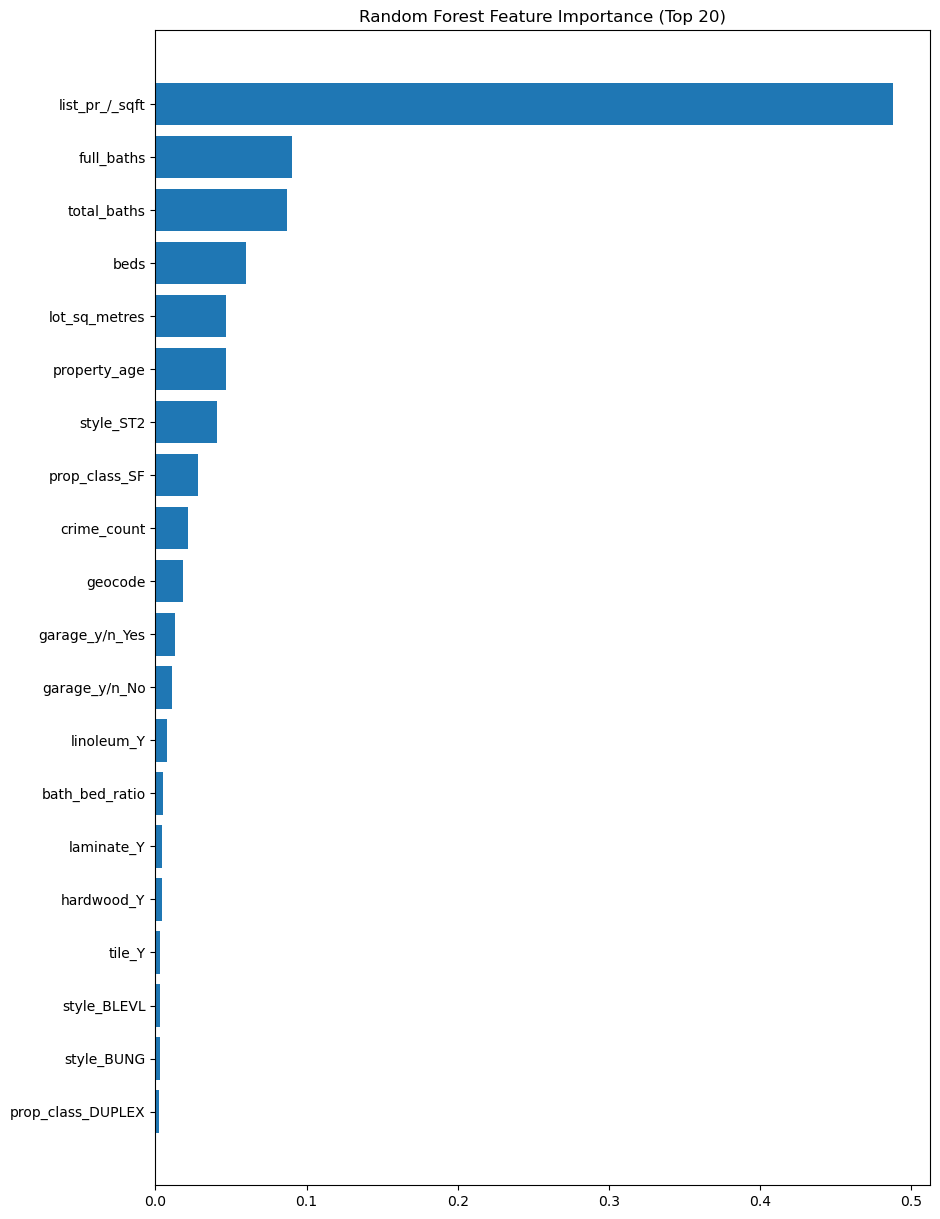

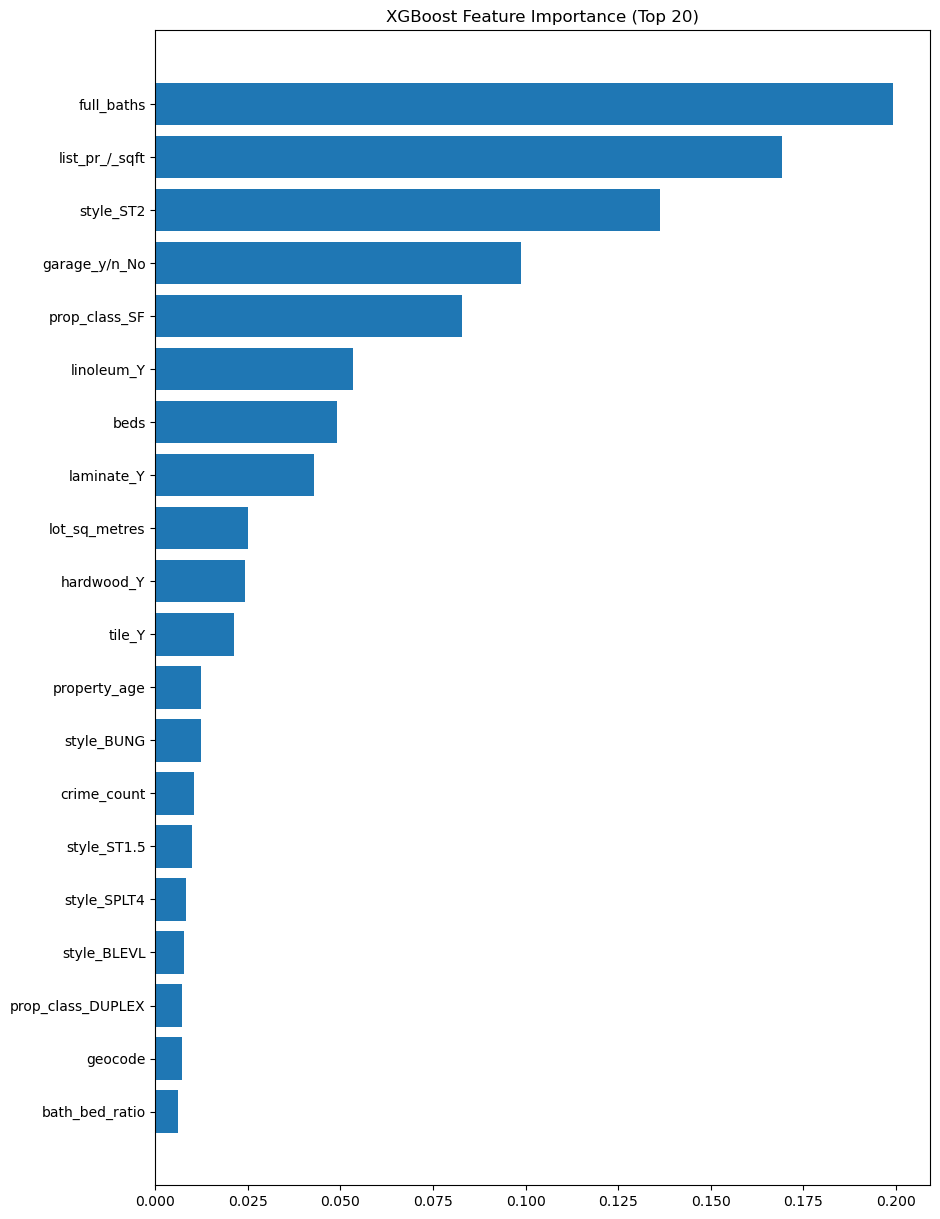

In [13]:
# Get feature names after preprocessing
# For numerical features
num_feature_names = numerical_features

# For categorical features (after one-hot encoding)
preprocessor.fit(X_train)
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Combine all feature names
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# Plot feature importance for Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)

importances = rf_pipeline.named_steps['model'].feature_importances_
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 15))
plt.barh(range(len(sorted_idx[-20:])), importances[sorted_idx[-20:]])
plt.yticks(range(len(sorted_idx[-20:])), all_feature_names[sorted_idx[-20:]])
plt.title("Random Forest Feature Importance (Top 20)")
plt.show()

# Plot feature importance for XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])
xgb_pipeline.fit(X_train, y_train)

importances = xgb_pipeline.named_steps['model'].feature_importances_
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 15))
plt.barh(range(len(sorted_idx[-20:])), importances[sorted_idx[-20:]])
plt.yticks(range(len(sorted_idx[-20:])), all_feature_names[sorted_idx[-20:]])
plt.title("XGBoost Feature Importance (Top 20)")
plt.show()

## Feature Importance Interpretation – Random Forest Model

This chart highlights the **top 20 features** that the Random Forest model uses to predict Edmonton property prices. The longer the bar, the more influence that feature has on the final price prediction.

### Key Insights

| Rank | Feature | Description | Why It Matters |
|------|---------|-------------|----------------|
| 1️⃣ | `list_pr_/sqft` | Listing price per square foot | A strong indicator of how the market values similar properties nearby. |
| 2️⃣ | `total_baths` | Total number of bathrooms | Homes with more bathrooms typically command higher prices. |
| 3️⃣ | `full_baths` | Number of full bathrooms | Full baths add more value than half baths. |
| 4️⃣ | `beds` | Number of bedrooms | More bedrooms increase utility and market appeal. |
| 5️⃣ | `lot_sq_metres` | Lot size in square meters | Larger lots tend to raise property value. |
| 6️⃣ | `property_age` | Age of the property | Newer properties are generally valued higher; older homes may need renovations. |
| 7️⃣ | `style_ST1.5` | Home style: 1.5 Storey | Certain architectural styles are more desirable in Edmonton's market. |
| 8️⃣ | `prop_class_DUPLEX` | Property type: Duplex | Duplexes may be valued differently due to investment potential. |
| 9️⃣ | `crime_count` | Crime rate in the area | Lower crime rates are typically associated with higher property values. |
| 🔟 | `geocode` | Neighborhood/location proxy | Captures spatial effects like school zones, amenities, and zoning. |

### What This Means for Real Estate Stakeholders

- **Buyers**: Understand which features drive prices in your target neighborhoods.
- **Sellers**: Know what to highlight in listings or improve before selling.
- **Agents & Developers**: Use these insights to guide pricing strategies and renovation decisions.
- **Urban Planners & Policy Makers**: Recognize the impact of neighborhood safety and housing types on market values.

This understanding helps ensure our predictive model is both **accurate and actionable**, supporting better decisions in Edmonton's real estate market.

## Comparing Feature Importances: Random Forest vs. XGBoost

Both models offer valuable perspectives on what drives property values in Edmonton.

| Rank | Random Forest Features | XGBoost Features |
|------|-------------------------|------------------|
| 1️⃣ | `list_pr_/sqft` | `full_baths` |
| 2️⃣ | `total_baths` | `style_ST1.5` |
| 3️⃣ | `full_baths` | `list_pr_/sqft` |
| 4️⃣ | `beds` | `year_built_category_Pre-1980` |
| 5️⃣ | `lot_sq_metres` | `prop_class_DUPLEX` |
| 6️⃣ | `property_age` | `hardwood_Y` |
| 7️⃣ | `style_ST1.5` | `beds` |
| 8️⃣ | `prop_class_DUPLEX` | `style_ST2` |
| 9️⃣ | `crime_count` | `tile_Y` |
| 🔟 | `geocode` | `linoleum_Y` |

**Interpretation:**
- Features like `full_baths`, `list_pr_/sqft`, and `beds` are important in both models.
- Random Forest emphasizes size and spatial attributes.
- XGBoost places higher weight on style, finish, and build-era nuances.
- These differences can guide renovation decisions, investment evaluations, and policy planning.


## Improving Random Forest with RandomizedSearchCV

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Sample 30% of the training set
X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train_final, y_train, train_size=0.3, random_state=42)


# 1. Prepare the Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# 2. Define the parameter distributions for random search
param_distributions = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': [None] + list(range(5, 30)),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 10),
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__bootstrap': [True, False]
}

# 3. Set up RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter combinations to try
    scoring='neg_mean_squared_error',  # We'll use RMSE for evaluation
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# 4. Fit the random search
rf_random_search.fit(X_train_sampled, y_train_sampled)

# 5. Evaluate the best model
best_rf = rf_random_search.best_estimator_
y_pred = best_rf.predict(X_test_final)

print("\nOptimized Random Forest Performance:")
print(f"Best Parameters: {rf_random_search.best_params_}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R2: {r2_score(y_test, y_pred):.2f}")

# 6. Compare with baseline RF
baseline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
baseline_rf.fit(X_train, y_train)
y_pred_baseline = baseline_rf.predict(X_test)

print("\nBaseline Random Forest Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_baseline)):.2f}")
print(f"R2: {r2_score(y_test, y_pred_baseline):.2f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END model__bootstrap=True, model__max_depth=23, model__max_features=auto, model__min_samples_leaf=8, model__min_samples_split=6, model__n_estimators=120; total time=   0.3s
[CV] END model__bootstrap=True, model__max_depth=23, model__max_features=auto, model__min_samples_leaf=8, model__min_samples_split=6, model__n_estimators=120; total time=   0.3s
[CV] END model__bootstrap=True, model__max_depth=23, model__max_features=auto, model__min_samples_leaf=8, model__min_samples_split=6, model__n_estimators=120; total time=   0.3s
[CV] END model__bootstrap=True, model__max_depth=23, model__max_features=auto, model__min_samples_leaf=8, model__min_samples_split=6, model__n_estimators=120; total time=   0.3s
[CV] END model__bootstrap=True, model__max_depth=23, model__max_features=auto, model__min_samples_leaf=8, model__min_samples_split=6, model__n_estimators=120; total time=   0.3s
[CV] END model__bootstrap=True, model__max_depth

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END model__bootstrap=False, model__max_depth=26, model__max_features=log2, model__min_samples_leaf=7, model__min_samples_split=4, model__n_estimators=492; total time=  33.3s
[CV] END model__bootstrap=False, model__max_depth=26, model__max_features=log2, model__min_samples_leaf=7, model__min_samples_split=4, model__n_estimators=492; total time=  35.3s
[CV] END model__bootstrap=False, model__max_depth=26, model__max_features=log2, model__min_samples_leaf=7, model__min_samples_split=4, model__n_estimators=492; total time=  35.5s
[CV] END model__bootstrap=True, model__max_depth=18, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=451; total time=  30.7s
[CV] END model__bootstrap=True, model__max_depth=18, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=451; total time=  30.6s
[CV] END model__bootstrap=True, model__max_depth=18, model__max_features=sqrt, model__min_samples_leaf=3, m

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
80 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimato


Optimized Random Forest Performance:
Best Parameters: {'model__bootstrap': True, 'model__max_depth': 22, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 3, 'model__n_estimators': 144}
RMSE: 55024.12
R2: 0.89

Baseline Random Forest Performance:
RMSE: 48265.13
R2: 0.92


## Exploring Neural Network

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score


# Separate features
numeric_features = X_train_final.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train_final.select_dtypes(include=['object', 'category']).columns.tolist()

# Build transformers
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Fit-transform train set
X_train_processed = preprocessor.fit_transform(X_train_final)
X_test_processed = preprocessor.transform(X_test_final)

# Define the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer='l2'), 
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dropout(0.2),
    Dense(16, activation='relu', kernel_regularizer='l2'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train_processed, y_train, validation_data=(X_test_processed, y_test), 
                    epochs=50, batch_size=64, verbose=1)

# Evaluate the model
y_pred_nn = model.predict(X_test_processed).flatten()
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network Performance:")
print(f"RMSE: {rmse_nn:.2f}")
print(f"R2: {r2_nn:.2f}")

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3994/3994 ━━━━━━━━━━━━━━━━━━━━ 4s 730us/step - loss: 37203419136.0000 - mae: 134342.5312 - val_loss: 4949987840.0000 - val_mae: 46539.7344
Epoch 2/50
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 3s 693us/step - loss: 10932173824.0000 - mae: 74251.6016 - val_loss: 4823231488.0000 - val_mae: 45445.4219
Epoch 3/50
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 3s 726us/step - loss: 10669041664.0000 - mae: 73151.1797 - val_loss: 4900720640.0000 - val_mae: 45660.2344
Epoch 4/50
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 3s 736us/step - loss: 10548234240.0000 - mae: 72576.7891 - val_loss: 4518361088.0000 - val_mae: 44055.3281
Epoch 5/50
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 3s 739us/step - loss: 10531911680.0000 - mae: 72478.9766 - val_loss: 4369763840.0000 - val_mae: 43544.0898
Epoch 6/50
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 3s 702us/step - loss: 10487708672.0000 - mae: 72365.2891 - val_loss: 4424997888.0000 - val_mae: 43344.4648
Epoch 7/50
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 3s 689us/step - loss: 10358340608.0000 - mae: 71916.6406 - val_loss: 45653

## Exploring Alternative Models: Randomized CV and Neural Networks

To further improve the model's performance, we experimented with:

1. **Randomized Cross-Validation (RandomizedSearchCV)**:
    - Hyperparameter tuning was applied to the Random Forest model.
    - Despite extensive tuning, the R² score did not improve significantly beyond the baseline Random Forest model.

2. **Neural Networks**:
    - A feedforward neural network was implemented using TensorFlow/Keras.
    - The model was trained with various architectures (e.g., hidden layers, activation functions) and hyperparameters (e.g., learning rate, batch size).
    - However, the neural network struggled to outperform the Random Forest model, likely due to the tabular nature of the dataset and the relatively small size of the training data for deep learning.

---

### Final Model Selection

Given the results, we chose to proceed with the **Random Forest Model** due to its:
- High accuracy (R² = 0.92)
- Robustness to overfitting
- Interpretability (e.g., feature importance analysis)

---

### Recommendations for Future Improvements

1. **Feature Engineering**:
    - Explore additional derived features, such as proximity to amenities, school ratings, or public transport access.
    - Incorporate external datasets, such as economic indicators or housing market trends.

2. **Data Collection**:
    - Increase the dataset size by including more years of property sales data.
    - Collect more granular neighborhood-level data (e.g., walkability scores, air quality).

3. **Advanced Modeling**:
    - Experiment with ensemble methods like stacking or blending.
    - Use gradient boosting frameworks like LightGBM or CatBoost for further optimization.

4. **Neural Network Optimization**:
    - Use techniques like feature embedding for categorical variables.
    - Train on larger datasets to leverage the full potential of deep learning.


By addressing these areas, the model's predictive power and practical utility can be further enhanced, supporting more informed decision-making in Edmonton's real estate market.

## SHAP Explainability Analysis

To interpret the predictive power of our Random Forest model, we use SHAP (SHapley Additive exPlanations). SHAP helps explain how each feature impacts individual predictions — both positively and negatively.

- **Positive SHAP values** indicate a feature increases the predicted sale price.
- **Negative SHAP values** mean the feature decreases it.

/var/folders/j5/l4n1h3z533nbg7ks96r5chn80000gn/T/ipykernel_93094/2943506793.py:9: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'bool'):


Initializing explainer...
Preprocessing data...
Computing SHAP values for 200 samples...


100%|██████████| 4/4 [00:00<00:00, 200.89it/s]

SHAP computation completed in 0.02 seconds
Generating visualizations...


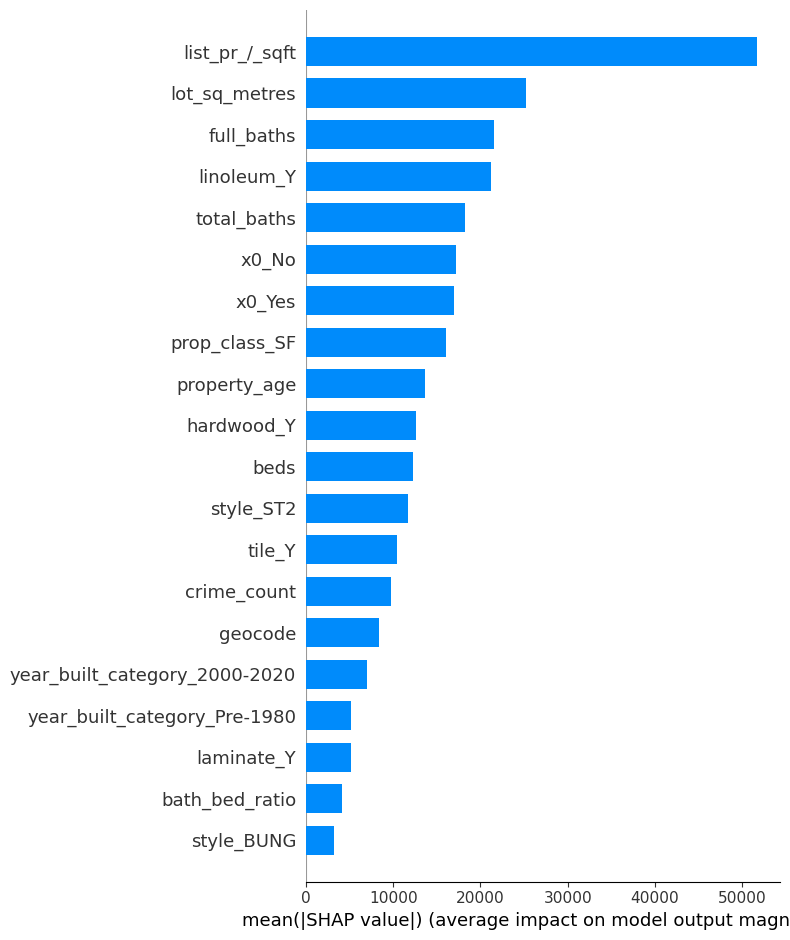

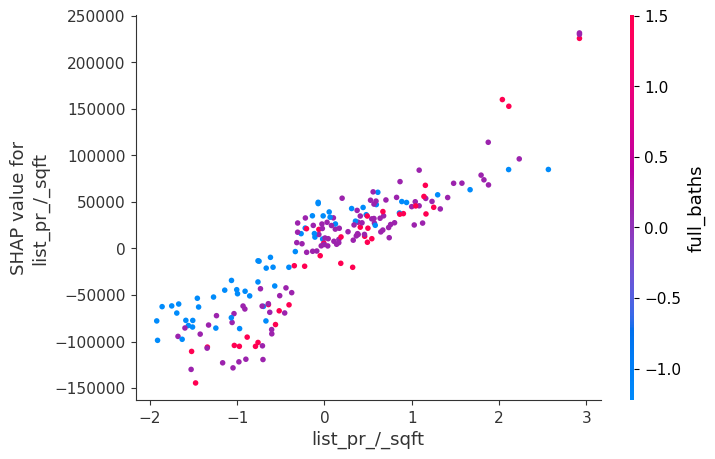

In [ ]:
import shap
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

# Temporary numpy bool fix if needed
if not hasattr(np, 'bool'):
    np.bool = bool

# 1. Prepare explainer
print("Initializing explainer...")
explainer = shap.TreeExplainer(best_rf.named_steps['model'])

# 2. Get preprocessed data
print("Preprocessing data...")
preprocessor = best_rf.named_steps['preprocessor']
X_test_final_processed = preprocessor.transform(X_test_final)
if hasattr(X_test_final_processed, 'toarray'):
    X_test_final_processed = X_test_final_processed.toarray()

# 3. Take a sample 
sample_size = 200  
sample_indices = np.random.choice(X_test_final_processed.shape[0], sample_size, replace=False)
X_sample = X_test_final_processed[sample_indices]

# 4. Compute SHAP values with progress monitoring
print(f"Computing SHAP values for {sample_size} samples...")
start_time = time.time()

# Batch processing for better memory management
batch_size = 50
shap_values = []
for i in tqdm(range(0, sample_size, batch_size)):
    batch = X_sample[i:i+batch_size]
    shap_values.extend(explainer.shap_values(batch, approximate=True, check_additivity=False))
    
shap_values = np.array(shap_values)
print(f"SHAP computation completed in {time.time()-start_time:.2f} seconds")

# 5. Get feature names
numeric_features = preprocessor.named_transformers_['num'].get_feature_names_out()
categorical_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()
all_feature_names = np.concatenate([numeric_features, categorical_features])

# 6. Create visualizations
print("Generating visualizations...")
shap.summary_plot(shap_values, X_sample, feature_names=all_feature_names, plot_type='bar')

# For specific feature analysis
if 'list_pr_/_sqft' in all_feature_names:
    feature_idx = np.where(all_feature_names == 'list_pr_/_sqft')[0][0]
    shap.dependence_plot(feature_idx, shap_values, X_sample, 
                        feature_names=all_feature_names, show=False)
    
    # Show original values if available
    if 'list_pr_/_sqft' in X_test_final.columns:
        plt.scatter(X_test_final.iloc[sample_indices]['list_pr_/_sqft'], 
                   shap_values[:, feature_idx],
                   alpha=0.3)
        plt.show()

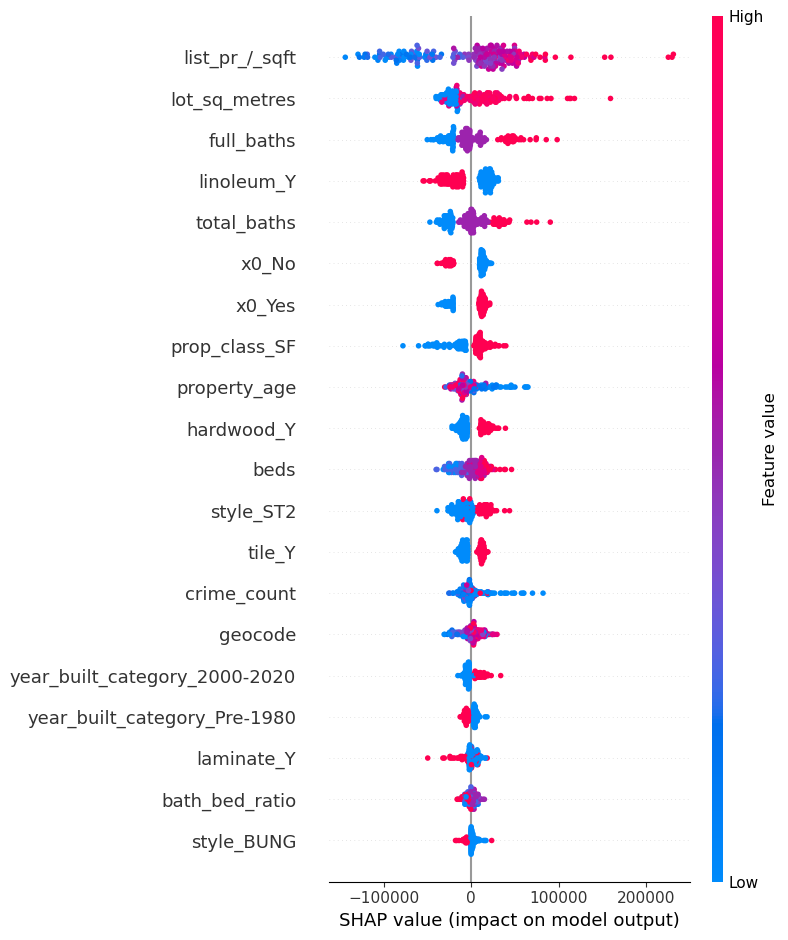

In [17]:
shap.summary_plot(shap_values, X_sample, feature_names=all_feature_names)

## SHAP Analysis: Interpreting Feature Impact

To gain deeper insight into how each feature contributes to our model’s predictions, we used **SHAP (SHapley Additive exPlanations)** values. SHAP provides a unified measure of feature importance and explains the contribution of each feature to the final prediction at both a global and individual level.

### SHAP Summary Plot (Global Importance)

The first plot shows the **mean absolute SHAP value** for each feature, indicating the average impact on the model's prediction. 

- `list_pr_/_sqft` has the **largest influence**, suggesting that the listing price per square foot is a dominant factor in predicting final sale price.
- Features like `lot_sq_metres`, `full_baths`, and `linoleum_Y` also have substantial impact.
- Categorical flooring types (e.g., `hardwood_Y`, `tile_Y`) show moderate importance.

### SHAP Dependence Plot

This plot reveals how changes in `list_pr_/_sqft` affect the model's predicted price. Points are colored by the value of `full_baths`:

- A clear **positive correlation** is observed: higher list price per square foot increases predicted sale price.
- Interestingly, points with more full bathrooms (darker shades) tend to have higher SHAP contributions.

### SHAP Beeswarm Plot (Local Interpretation)

This plot illustrates the **distribution of SHAP values** for each feature across all predictions:

- High values of features on the **right side** contribute to higher price predictions (positive SHAP value).
- Low values on the **left** reduce the prediction.
- `list_pr_/_sqft`, `lot_sq_metres`, and `full_baths` consistently push prices up when their values are high.

---

## Final Summary

This predictive modeling project successfully combined property listings, crime data, and neighborhood metadata to estimate real estate sale prices in Edmonton. Key highlights include:

- **Top features**: `list_pr_/_sqft`, `property_age`, `total_baths`, `lot_sq_metres`, and flooring types significantly influenced pricing.
- **Interpretability**: SHAP analysis allowed us to understand both global and local feature contributions, supporting decision-making and stakeholder communication.
